In [1]:
import sys, os
import utils

sys.path.insert(0, os.path.abspath('../DeepSplines'))
from deepsplines.ds_modules.deepBspline import DeepBSpline
from models import LinearBSpline


opt_params = {
        'size': 3,
        'range_': 1,
        'init': 'relu',
        'save_memory': False
}

bspline = DeepBSpline('fc', 8, **opt_params) # create a single BSpline Layer

locations = bspline.grid_tensor.detach()
coefficients = bspline.coefficients_vect.view(bspline.num_activations, bspline.size).detach()

# print(locations)
# print(coefficients)

# utils.plot_bspline(locs=locations[0].numpy(), coeffs=coefficients[0].numpy)


In [2]:
import linspline
import matplotlib.pyplot as plt
import numpy as np
import torch

import importlib

importlib.reload(linspline)

linspline = linspline.LinearSpline(locations[0], coefficients[0])

(locs, coeffs) = linspline.get_locs_coeffs()

x_plot = x_plot = torch.from_numpy(np.linspace(-1, 1, 400))
y_plot = linspline.forward(x_plot)


plt.figure(figsize=(8, 6))
plt.plot(x_plot, y_plot, label='Linear Spline', color='blue')
plt.scatter(locs, coeffs, color='red', label='Knot Points')
plt.title('Linear Spline Interpolation using NumPy.interp')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: module 'linspline' has no attribute 'LinearSpline'

Now copy model to model

In [3]:
model = LinearBSpline([8], 3, 1, 'relu') # create a BSpline based model

for layer in range(len(model.get_deepspline_activations())):
    locs = model.get_deepspline_activations()[layer]['locations']
    coeffs = model.get_deepspline_activations()[layer]['coefficients']

In [ ]:
# ! test timing on single bspline vs. linear spline vs. relu 

In [4]:
import linspline
import importlib

importlib.reload(linspline)

lin_model = linspline.LSplineFromBSpline(model.get_layers())

print("\n----\n")
print(lin_model.get_layers())


----

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): LinearSplineLayer(locs=Tensor(shape=(8, 3)), coeffs=Tensor(shape=(8, 3)), mode='fc')
  (2): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
import linspline
import importlib
import time

import torch.nn as nn

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

importlib.reload(linspline)

housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

loss_fn = nn.MSELoss()

model = LinearBSpline([8], 3, 1)

start_time = time.perf_counter()
_ = model(X_test)

end_time = time.perf_counter()
fwd_lat = (end_time - start_time) / len(X_test) * 1000 * 1000 # per sample latency: seconds -> nanoseconds
fwd_lat = round(fwd_lat, 4)

print(f"BSpline fwd lat: {fwd_lat}")

# ~ ---------

lin_model = linspline.LSplineFromBSpline(model.get_layers())

start_time = time.perf_counter()
_ = lin_model(X_test)

end_time = time.perf_counter()
fwd_lat = (end_time - start_time) / len(X_test) * 1000 * 1000 # per sample latency: seconds -> nanoseconds
fwd_lat = round(fwd_lat, 4)
print(f"LSpline fwd lat: {fwd_lat}")

# may need to continue training on the linear splines...

BSpline fwd lat: 0.3702
LSpline fwd lat: 0.3893


In [14]:
sys.path.insert(0, os.path.abspath('../DeepSplines'))
from deepsplines.ds_modules.deepBspline import DeepBSpline
import deepsplines
import utils

layer_locs = []
layer_coeffs = []
for layer in model.get_layers():
    if(type(layer) is deepsplines.ds_modules.deepBspline.DeepBSpline):
        layer_locs.append(layer.grid_tensor.detach())
        layer_coeffs.append(layer.coefficients_vect.view(layer.num_activations, layer.size).detach())

In [15]:
import linspline

layer_locs2 = []
layer_coeffs2 = []
for layer in lin_model.get_layers():
    if(type(layer) is not torch.nn.modules.linear.Linear):
        print(type(layer))
        (l2, c2) = layer.get_locs_coeffs()
        
        layer_locs2.append(l2)
        layer_coeffs2.append(c2)


<class 'linspline.LinearSplineLayer'>


## Here

In [2]:
import time, torch

input_dim = 8
batch_size = 10

def run_layer(layer, input_dim, batch_size):
    #print(layer)
    start_time = time.perf_counter()
    n=1000
    inputs = [ torch.rand(batch_size, input_dim) * 3 - 1.5 for _ in range(n) ]
    # print("Example input: ", inputs[0])
    for i in range(n):
        _ = layer(inputs[i])
    return time.perf_counter() - start_time # time to process n inputs

In [4]:
from deepspeed.profiling.flops_profiler import get_model_profile
def get_model_params(model, input_size=8):
    base_flops, macs, params = get_model_profile(model=model, # model
            input_shape=(batch_size, input_size), # input shape to the model. If specified, the model takes a tensor with this shape as the only positional argument.
            args=None, # list of positional arguments to the model.
            kwargs=None, # dictionary of keyword arguments to the model.
            print_profile=False, #! prints the model graph with the measured profile attached to each module
            detailed=True, # print the detailed profile
            module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
            top_modules=1, # the number of top modules to print aggregated profile
            warm_up=10, # the number of warm-ups before measuring the time of each module
            as_string=False, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
            output_file=None, # path to the output file. If None, the profiler prints to stdout.
            ignore_modules=None)

    return params

[2025-01-02 20:30:52,049] [WARNING] [real_accelerator.py:174:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-01-02 20:30:52,085] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cpu (auto detect)


In [5]:
from models import LinearReLU, LinearBSpline
import linspline
import importlib
from IPython.display import clear_output

importlib.reload(linspline)

archs = [[8,8], [8,8,8], [8,24,8], [8, 24, 48, 24, 8], [8, 24, 48, 96, 48, 24, 8]]
relu_results = []
bspline_results = []
lspline_results = []

for arch in archs:
    reluModel = LinearReLU(arch)
    # run_layer(reluModel.layers[1], input_dim, batch_size)
    relu_results.append((get_model_params(reluModel), run_layer(reluModel, input_dim, batch_size)))

    bsplineModel = LinearBSpline(arch, 3, 1, "relu")
    spline_params = get_model_params(bsplineModel) #! not actually true... need to figure out why bspline has fewer params
    # run_layer(bsplineModel.get_layers()[1], input_dim, batch_size)
    bspline_results.append((spline_params, run_layer(bsplineModel, input_dim, batch_size)))

    linModel = linspline.LSplineFromBSpline(bsplineModel.get_layers())
    # run_layer(linModel.get_layers()[1], input_dim, batch_size)
    lspline_results.append((spline_params, run_layer(linModel, input_dim, batch_size)))

clear_output()
print(relu_results)
print(bspline_results)
print(lspline_results)

[(153, 0.07044262392446399), (225, 0.09166636597365141), (497, 0.12815096112899482), (2873, 0.18513392098248005), (12233, 0.2546231998130679)]
[(201, 0.5630547080654651), (297, 0.8169881771318614), (617, 0.8803278179839253), (3209, 1.4166555360425264), (13001, 2.0186847380828112)]
[(201, 0.2731004930101335), (297, 0.38378298305906355), (617, 0.4362629798706621), (3209, 0.7260007809381932), (13001, 1.053679727949202)]


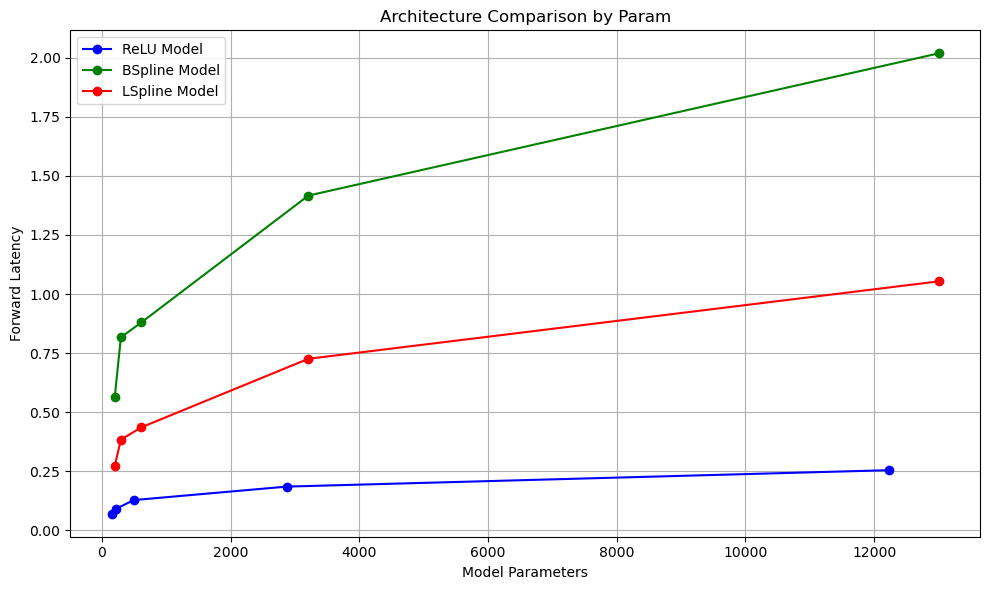

In [7]:
import matplotlib.pyplot as plt

# Assuming relu_results, bspline_results, and lspline_results contain (idx, result) tuples
relu_indices = [result[0] for result in relu_results]
relu_values = [result[1] for result in relu_results]

bspline_indices = [result[0] for result in bspline_results]
bspline_values = [result[1] for result in bspline_results]

lspline_indices = [result[0] for result in lspline_results]
lspline_values = [result[1] for result in lspline_results]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model's results
plt.plot(relu_indices, relu_values, label="ReLU Model", marker='o', linestyle='-', color='b')
plt.plot(bspline_indices, bspline_values, label="BSpline Model", marker='o', linestyle='-', color='g')
plt.plot(lspline_indices, lspline_values, label="LSpline Model", marker='o', linestyle='-', color='r')

# Labeling the axes and the plot
plt.xlabel("Model Parameters")
plt.ylabel("Forward Latency")
plt.title("Architecture Comparison by Param")
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from models import LinearBSpline

from torch.utils.data import TensorDataset, DataLoader

# By default, PyTorch attempts to use all available CPU cores for intra-op parallelism. Set threads = cpu cores
torch.set_num_threads(1)

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# using a dataloader to randomize batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

loss_fn = nn.MSELoss()  # mean square error

lmbda = 1e-4 # regularization weight

bsm = LinearBSpline([8], 3, 1, "relu")
optimizer = optim.Adam(bsm.parameters_no_deepspline(), lr=0.001)
aux_optimizer = optim.Adam(bsm.parameters_deepspline(), lr=0.0001)

print("Init complete")

bsm.train()
for epoch in range(20):
    rloss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        aux_optimizer.zero_grad()

        y_pred = bsm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss2 = loss + lmbda * bsm.TV2()
        loss2.backward()
        optimizer.step()
        aux_optimizer.step()
        
        rloss += loss
    if(epoch % 5 == 0):
        print(f"Epoch {epoch}: {rloss}")


Init complete
Epoch 0: 5808.34423828125
Epoch 5: 1977.736572265625
Epoch 10: 1365.8917236328125
Epoch 15: 2391.31884765625


In [51]:
import time, importlib, utils
importlib.reload(linspline)
importlib.reload(utils)

reluModel = LinearReLU([8])
layer = reluModel.layers[1]
print("Relu:")
run_layer(layer, 8)
run_layer(reluModel, 8)

print("\n ---- \n")

layer = bsm.get_layers()[1]
print("BSpline:")
run_layer(layer, 8)
run_layer(bsm, 8)

print("\n ---- \n")


print("Transferred LSpline")
lin = linspline.LSplineFromBSpline(bsm.get_layers())
layer = lin.get_layers()[1]
print("LSpline:")
run_layer(layer, 8)
run_layer(lin, 8)


# layer_locs = layer.grid_tensor.detach()[0]
# layer_coeffs = layer.coefficients_vect.view(layer.num_activations, layer.size).detach()[0]
# utils.plot_bspline(layer_locs, layer_coeffs, hide_bases=True)

Relu:
Example input:  tensor([[-0.8757, -0.8190, -0.7289, -0.1208,  0.3713, -0.0796,  1.4801,  0.6800]])
0.02407547098118812
Example input:  tensor([[ 1.3672, -0.3730, -1.2520,  0.3729, -1.0686, -1.2044,  0.6517,  0.5266]])
0.05123466602526605

 ---- 

BSpline:
Example input:  tensor([[ 0.3143, -0.6568, -1.1178, -0.4033, -0.3168,  0.1962, -0.0949,  0.0265]])
0.2497409119969234
Example input:  tensor([[-0.2520,  1.1274, -1.1364,  0.8665, -0.6309, -0.5737,  0.9170, -0.9641]])
0.293678083922714

 ---- 

Transferred LSpline
LSpline:
Example input:  tensor([[ 1.4577, -1.2524,  0.4339, -1.1763, -0.1010,  1.4335,  0.2256, -1.4218]])
0.13074749999213964
Example input:  tensor([[-1.2117, -0.3120, -0.6229,  0.9677,  0.6571,  0.6464,  1.4126, -0.0633]])
0.17072065104730427


In [18]:
lin_layer = linModel.get_layers()[1]
(linlocs, lincoeffs) = lin_layer.get_locs_coeffs()
# utils.plot_bspline(linlocs[0], lincoeffs[0], hide_bases=True)

Transferred LSpline
time:  293.79199258983135
tensor([[-0.2737, -0.0244],
        [ 0.0382,  0.0082],
        [ 1.8457,  0.0412]])


In [19]:
lin_optimizer = optim.Adam(linModel.parameters(), lr=0.001)

print("Init complete")

linModel.train()
for epoch in range(10):
    rloss = 0
    for X_batch, y_batch in train_loader:
        lin_optimizer.zero_grad()

        y_pred = linModel(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        rloss += loss
    print(f"Epoch {epoch}: {rloss}")

layer = linModel.get_layers()[1]
run_layer(layer, input)

Init complete
Epoch 0: 1173.4237060546875
Epoch 1: 1279.8961181640625
Epoch 2: 1145.614990234375
Epoch 3: 1148.69677734375
Epoch 4: 1183.909423828125
Epoch 5: 1157.4105224609375
Epoch 6: 1178.8897705078125
Epoch 7: 1164.2030029296875
Epoch 8: 1176.5655517578125
Epoch 9: 1152.094482421875
time:  320.02292573451996
tensor([[-0.2737, -0.0244],
        [ 0.0382,  0.0082],
        [ 1.8457,  0.0412]])


In [ ]:
from models import LinearRelu

relu = LinearRelu([8])
optimizer = optim.Adam(bsm.parameters_no_deepspline(), lr=0.001)

print("Init complete")

relu.train()
for epoch in range(100):
    rloss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = bsm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss2 = loss + lmbda * bsm.TV2()
        loss2.backward()
        optimizer.step()
        
        rloss += loss
    if(epoch % 5 == 0):
        print(f"Epoch {epoch}: {rloss}")

In [15]:
import matplotlib.pyplot as plt

x = torch.linspace(-1, 1, 1000, dtype=torch.float)

# Compute y values based on the new function
y1 = layer(x)
y2 = lin_layer(x)

# # Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='BSpline', color='red', alpha = .5)
plt.plot(x, y2, label='LSpline', color='blue', alpha = .5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)